In [1]:
## imports
import matplotlib.pyplot as plt
from src.plot_utils import *
from src.sim_utils import *
import yaml
import numpy as np
import jax.numpy as jnp
import sparse
from hydra import initialize, compose
from hydra.core.hydra_config import HydraConfig
from omegaconf import DictConfig, OmegaConf
from pathlib import Path, PosixPath
import h5py

In [2]:
## plotting defaults
plt.rcParams["font.sans-serif"] = "Arial"
plt.rcParams["axes.spines.right"] = "False"
plt.rcParams["axes.spines.top"] = "False"
plt.rcParams["svg.fonttype"] = "none"
plt.rcParams["figure.figsize"] = (2,2)
plt.rcParams['axes.linewidth'] = 0.25
plt.rcParams["xtick.major.size"] = 1.7
plt.rcParams["ytick.major.size"] = 1.7
plt.rcParams["xtick.major.width"] = 0.25
plt.rcParams["ytick.major.width"] = 0.25
plt.rcParams["figure.dpi"] = 200

SMALL_SIZE = 6
LABEL_SIZE = 7
AXLABEL_SIZE = 8
TITLE_SIZE = 10

plt.rcParams["font.family"] = "Arial" # "Arial"
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=AXLABEL_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=LABEL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=TITLE_SIZE)  # fontsize of the figure title

plt.rcParams["axes.labelpad"] = 1.5
plt.rcParams["xtick.major.pad"] = 1.5
plt.rcParams["ytick.major.pad"] = 1.5

moduleColors = get_module_colors()

dnColor = "#51bbad"
excColor = "#d84a2e"
inhColor = "#026b85"
mnColor = "#267655"

lightDnColor = "#a7dcd5ff"
lightExcColor = "#ff9985"

dataPath = "/data/users/smpuglie/Pugliese_2025/"

## MANC 1024x DNg100 activation

In [3]:
simType = "DNg100_Stim"
simPath = simType+"/hyak/run_id=28123286"
folder = dataPath + simPath
Rs = sparse.load_npz(folder+f"/ckpt/{simType}_Rs.npz").todense()
params = DictConfig(load_from_yaml(folder+"/logs/run_config.yaml"))

dataset = 0
Rs = Rs[dataset]
nSims = Rs.shape[0]
Rs.shape

(1024, 4604, 2001)

In [ ]:
wTable = pd.read_csv("../"+params.experiment["dfPath"].split("Pugliese_2025")[1])
mnData = sort_motor_modules(wTable.loc[wTable["motor module"].notna()])
nMnsActive = pd.Series(index=np.arange(nSims))
nMnsActivePastTransient = pd.Series(index=np.arange(nSims))
simScore = pd.Series(index=np.arange(nSims))

for i in range(nSims):
    # active neurons
    R = Rs[i]
    
    activeMnsMask = (np.max(R,1)>0.01) & (jnp.isin(jnp.arange(R.shape[0]), mnData.index.to_numpy()))
    nMnsActive.loc[i] = np.sum(activeMnsMask)
    activeMnsMaskPastTransient = (np.max(R[:,250:],1)>0.01) & (jnp.isin(jnp.arange(R.shape[0]), mnData.index.to_numpy()))
    score, _ = compute_oscillation_score(R[...,250:],activeMnsMaskPastTransient)
    nMnsActivePastTransient.loc[i] = np.sum(activeMnsMaskPastTransient)
    simScore.loc[i] = score

figFolder = "../figures/"
figFolder += "-".join(str.split(simPath,"/"))

/home/smpuglie/Pugliese_2025/src/plot_utils.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  neuronData[colName] = pd.Categorical(neuronData[colName],categories=["coxa swing", "coxa stance", "femur/tr extend", "femur/tr flex",


### individual traces

791


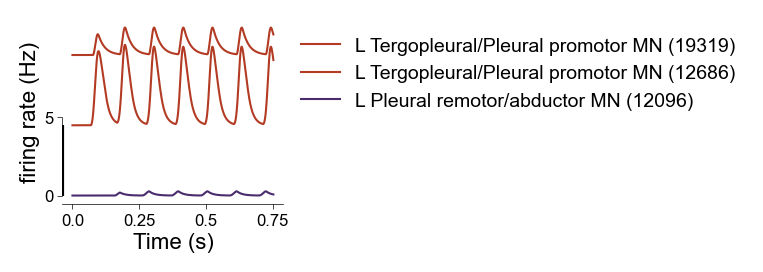

In [85]:
idx = np.random.randint(1000) 
spacer = 4.5
width = 3

R = Rs[idx]

plt.figure()
print(idx)
ax = plot_R_traces_stacked_by_module(R[:,:750],mnData,activeOnly=True,space=spacer)# ,colorMapper=colorMapper)
add_tAxis(ax,0.75,3.0001)
xlimits = ax.get_xlim()
plt.vlines(xlimits[0],0,5,"k",linewidth=0.25)
plt.yticks([0,5])
plt.xlim(xlimits)
ax.spines[["left","top","right"]].set_visible(False)
ax.tick_params(labelsize=6)
# ax.grid(axis="x",color="lightgrey",linestyle="--")
ax.grid(False)
plt.ylabel("firing rate (Hz)",fontsize=8)
# plt.xlabel("Time (s)",fontsize=8)
fig = plt.gcf()
# fig.set_figheight(0.5*len(get_active_data(R[mnData.index],mnData)))
# fig.set_figheight(2.5)
# fig.set_figwidth(width)

fig.set_figwidth(1.426)
fig.set_figheight(1.2)




plt.show()

530,819,854,**694**,**674**, 813 unrepresentative but interesting

/home/smpuglie/Pugliese_2025/src/plot_utils.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  neuronData[colName] = pd.Categorical(neuronData[colName],categories=["coxa swing", "coxa stance", "femur/tr extend", "femur/tr flex",


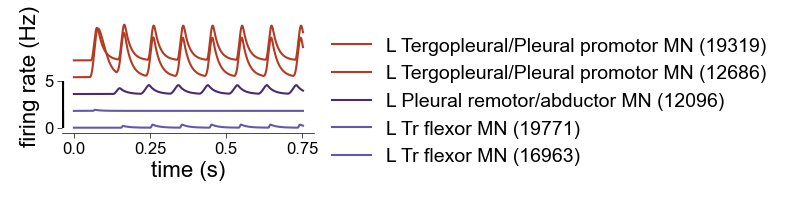

In [ ]:
idx = 694 #np.random.randint(nSims)
spacer = 3*3/5
scalebar = 5

timeLimit = .75

R = Rs[idx]

mnsToPlot = sort_motor_modules(wTable.loc[wTable["bodyId"].isin(mnIdsToPlot)])

plt.figure()
# ax = plot_R_traces_stacked_by_module(R[:,:int(timeLimit/params.sim.dt)],mnsToPlot,activeOnly=False,space=spacer)
ax = plot_R_traces_stacked_by_module(R[:,:750],mnData,activeOnly=True,space=spacer)# ,colorMapper=colorMapper)
add_tAxis(ax,timeLimit,3.00001)
xlimits = ax.get_xlim()
plt.vlines(xlimits[0],0,scalebar,"k")
plt.yticks([0,scalebar])
plt.xlim(xlimits)
ax.spines[["left","top","right"]].set_visible(False)
fig = plt.gcf()
fig.set_figheight(0.15*len(get_active_data(R[mnsToPlot.index],mnsToPlot)))
ax.grid(False)
plt.xlabel("time (s)")


fig.set_figwidth(1.626)
fig.set_figheight(1.226*3/5)
# fig.set_dpi(500)

if not os.path.exists(figFolder):
    os.makedirs(figFolder)
plt.savefig(figFolder+f"/mnTraces_idx{idx}.svg",transparent=True)
plt.show()

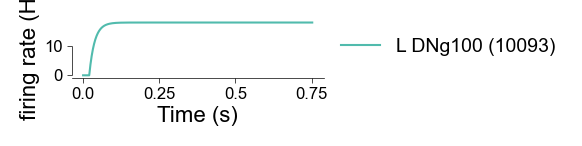

In [97]:
idx = 694 # np.random.randint(1000)
R = Rs[idx]
spacer=10

tIdxs = np.arange(0,1000)

dng100data = wTable.loc[[31,132]].copy()
dng100data["somaSide"] = ["LHS","RHS"]

plt.figure()
ax = plot_R_traces_stacked_2(R[:,:750],dng100data,activeOnly=True,space=spacer,colors=["#51bbad"])# ,colorMapper=colorMapper)
add_tAxis(ax,0.75,3.0001)
xlimits = ax.get_xlim()
plt.vlines(xlimits[0],0,10,"k",linewidth=0.25)
plt.yticks([0,10])
plt.xlim(xlimits)
ax.spines[["left","top","right"]].set_visible(False)
ax.grid(False)
plt.ylabel("firing rate (Hz)")
fig = plt.gcf()

fig.set_figwidth(1.626)
fig.set_figheight(0.377)

if not os.path.exists(figFolder):
    os.makedirs(figFolder)
plt.savefig(figFolder+f"/dng100trace_idx{idx}.svg",transparent=True)
plt.show()

### overall data

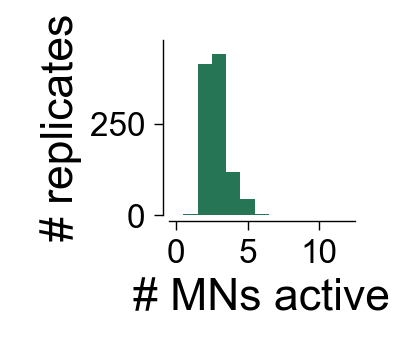

In [6]:
plt.figure(figsize=(0.600,0.57))

ax = sns.histplot(nMnsActive,color=mnColor,edgecolor="none",binwidth=1,kde=False,alpha=1,discrete=True)

plt.ylim([0,480])
plt.xlim([-0.5,12.5])
plt.xticks([0,5,10],labels=[0,5,10])
plt.ylabel("# replicates",fontsize=8)
plt.xlabel("# MNs active",fontsize=8)
plt.gca().tick_params(axis='both', which='major', labelsize=6)
plt.gcf().set_dpi(400)
sns.despine(offset=1)

if not os.path.exists(figFolder):
    os.makedirs(figFolder)
plt.savefig(figFolder+"/activeMnHist.svg",transparent=True)
plt.show()

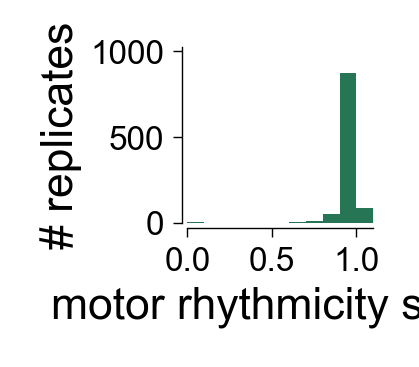

In [7]:
plt.figure(figsize=(0.600,0.57))

ax = sns.histplot(simScore,color=mnColor,edgecolor="none",bins=np.arange(0,1.5,0.1),kde=False,alpha=1.0)
plt.xlim([0,1.1])
plt.ylim([0,1024])
plt.yticks([0,500,1000])
plt.xticks(np.arange(0,1.1,0.5))
plt.xlabel("motor rhythmicity score",fontsize=8)
plt.ylabel("# replicates",fontsize=8)
plt.gca().tick_params(axis='both', which='major', labelsize=6)
plt.gcf().set_dpi(400)

sns.despine(offset=1)

if not os.path.exists(figFolder):
    os.makedirs(figFolder)
plt.savefig(figFolder+"/mnScoreHist.svg",transparent=True)
plt.show()

## FANC 1024x DNg100 activation

In [3]:
simType = "DNg100_Stim_FANC"
simPath = simType+"/walle-smpuglie/run_id=walle"
folder = dataPath + simPath
Rs = sparse.load_npz(folder+f"/ckpt/{simType}_Rs.npz").todense()
params = DictConfig(load_from_yaml(folder+"/.hydra/config.yaml"))

dataset = 0
Rs = Rs[dataset]
nSims = Rs.shape[0]
Rs.shape

(1024, 803, 2001)

In [4]:
wTable = pd.read_csv("../"+params.experiment["dfPath"].split("Pugliese_2025")[1])
mnData = sort_motor_modules(wTable.loc[wTable["motor module"].notna()])
nMnsActive = pd.Series(index=np.arange(nSims))
nMnsActivePastTransient = pd.Series(index=np.arange(nSims))
simScore = pd.Series(index=np.arange(nSims))

for i in range(nSims):
    # active neurons
    R = Rs[i]
    
    activeMnsMask = (np.max(R,1)>0.01) & (jnp.isin(jnp.arange(R.shape[0]), mnData.index.to_numpy()))
    nMnsActive.loc[i] = np.sum(activeMnsMask)
    activeMnsMaskPastTransient = (np.max(R[:,250:],1)>0.01) & (jnp.isin(jnp.arange(R.shape[0]), mnData.index.to_numpy()))
    score, _ = compute_oscillation_score(R[...,250:],activeMnsMaskPastTransient)
    nMnsActivePastTransient.loc[i] = np.sum(activeMnsMaskPastTransient)
    simScore.loc[i] = score

figFolder = "../figures/"
figFolder += "-".join(str.split(simPath,"/"))

/home/smpuglie/Pugliese_2025/src/plot_utils.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  neuronData[colName] = pd.Categorical(neuronData[colName],categories=["coxa swing", "coxa stance", "femur/tr extend", "femur/tr flex",


### individual traces

99
0.9796184301376343


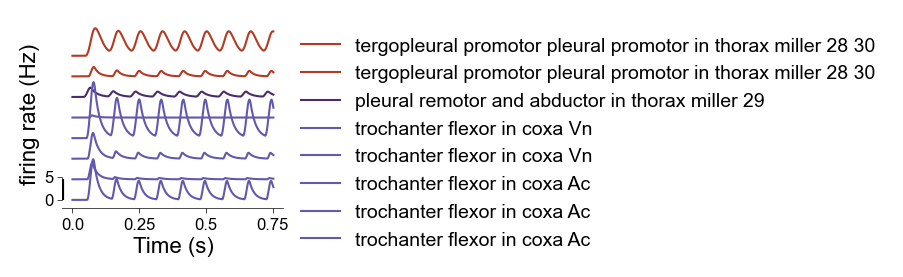

In [59]:
idx = np.random.randint(1000) 
spacer = 4.5
width = 3

R = Rs[idx]

plt.figure()
print(idx)
ax = plot_R_traces_stacked_by_module(R[:,:750],mnData,activeOnly=True,space=spacer,fanc=True)# ,colorMapper=colorMapper)
add_tAxis(ax,0.75,3.0001)
xlimits = ax.get_xlim()
plt.vlines(xlimits[0],0,5,"k",linewidth=0.25)
plt.yticks([0,5])
plt.xlim(xlimits)
ax.spines[["left","top","right"]].set_visible(False)
ax.tick_params(labelsize=6)
# ax.grid(axis="x",color="lightgrey",linestyle="--")
ax.grid(False)
plt.ylabel("firing rate (Hz)",fontsize=8)
# plt.xlabel("Time (s)",fontsize=8)
fig = plt.gcf()
# fig.set_figheight(0.5*len(get_active_data(R[mnData.index],mnData)))
# fig.set_figheight(2.5)
# fig.set_figwidth(width)

fig.set_figwidth(1.426)
fig.set_figheight(1.226)

print(simScore[idx])
plt.show()

761, 99

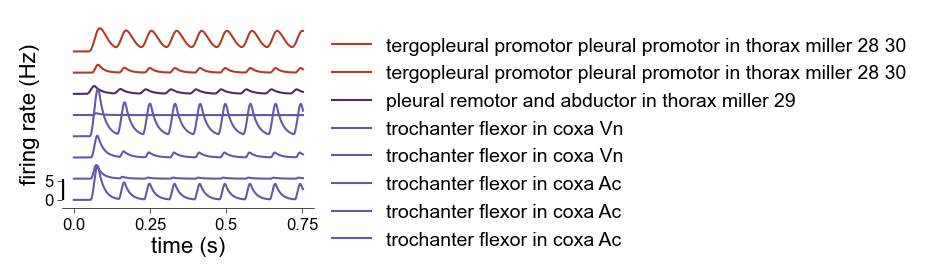

In [67]:
idx = 99 #np.random.randint(nSims)
spacer = 5.5
scalebar = 5

timeLimit = .75

R = Rs[idx]

plt.figure()
ax = plot_R_traces_stacked_by_module(R[:,:750],mnData,activeOnly=True,space=spacer,fanc=True)# ,colorMapper=colorMapper)
add_tAxis(ax,timeLimit,3.00001)
xlimits = ax.get_xlim()
plt.vlines(xlimits[0],0,scalebar,"k")
plt.yticks([0,scalebar])
plt.xlim(xlimits)
ax.spines[["left","top","right"]].set_visible(False)
fig = plt.gcf()
ax.grid(False)
plt.xlabel("time (s)")


fig.set_figwidth(1.626)
fig.set_figheight(1.226)
# fig.set_dpi(500)

if not os.path.exists(figFolder):
    os.makedirs(figFolder)
plt.savefig(figFolder+f"/mnTraces_idx{idx}.svg",transparent=True)
plt.show()

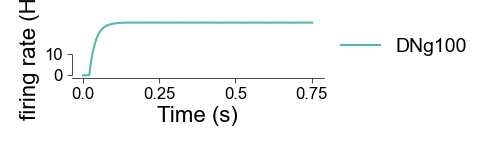

In [72]:
idx = 99 # np.random.randint(1000)
R = Rs[idx]
spacer=10

tIdxs = np.arange(0,1000)

dng100data = wTable.loc[[0]].copy()

plt.figure()
ax = plot_R_traces_stacked_2(R[:,:750],dng100data,activeOnly=True,space=spacer,colors=["#51bbad"],fanc=True)
add_tAxis(ax,0.75,3.0001)
xlimits = ax.get_xlim()
plt.vlines(xlimits[0],0,10,"k",linewidth=0.25)
plt.yticks([0,10])
plt.xlim(xlimits)
ax.spines[["left","top","right"]].set_visible(False)
ax.grid(False)
plt.ylabel("firing rate (Hz)")
fig = plt.gcf()

fig.set_figwidth(1.626)
fig.set_figheight(0.377)

if not os.path.exists(figFolder):
    os.makedirs(figFolder)
plt.savefig(figFolder+f"/dng100trace_idx{idx}.svg",transparent=True)
plt.show()

### overall data

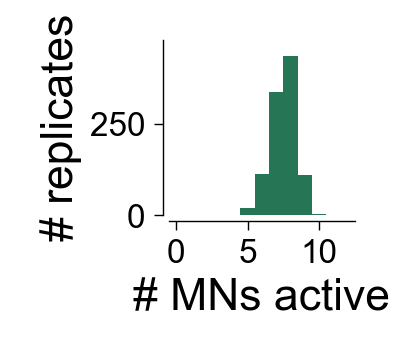

In [5]:
plt.figure(figsize=(0.600,0.57))

ax = sns.histplot(nMnsActive,color=mnColor,edgecolor="none",binwidth=1,kde=False,alpha=1,discrete=True)

plt.ylim([0,480])
plt.xlim([-0.5,12.5])
plt.xticks([0,5,10],labels=[0,5,10])
plt.ylabel("# replicates",fontsize=8)
plt.xlabel("# MNs active",fontsize=8)
plt.gca().tick_params(axis='both', which='major', labelsize=6)
plt.gcf().set_dpi(400)
sns.despine(offset=1)

if not os.path.exists(figFolder):
    os.makedirs(figFolder)
plt.savefig(figFolder+"/activeMnHist.svg",transparent=True)
plt.show()

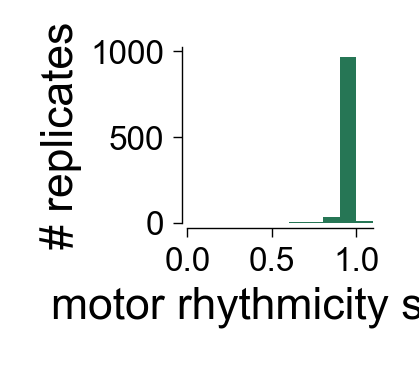

In [10]:
plt.figure(figsize=(0.600,0.57))

ax = sns.histplot(simScore,color=mnColor,edgecolor="none",bins=np.arange(0,1.5,0.1),kde=False,alpha=1.0)
plt.xlim([0,1.1])
plt.ylim([0,1024])
plt.yticks([0,500,1000])
plt.xticks(np.arange(0,1.1,0.5))
plt.xlabel("motor rhythmicity score",fontsize=8)
plt.ylabel("# replicates",fontsize=8)
plt.gca().tick_params(axis='both', which='major', labelsize=6)
plt.gcf().set_dpi(400)

sns.despine(offset=1)

if not os.path.exists(figFolder):
    os.makedirs(figFolder)
plt.savefig(figFolder+"/mnScoreHist.svg",transparent=True)
plt.show()

## MANC DNg100 activation $w_{ij}$ noise $\sigma$ sweep

In [67]:
simType = "DNg100_Stim"
simPath = simType+"/hyak/run_id=28132259"
folder = dataPath + simPath
overallParams = DictConfig(load_from_yaml(folder+"/multirun.yaml"))
wTable = pd.read_csv("../"+overallParams.experiment["dfPath"].split("Pugliese_2025")[1])
mnData = sort_motor_modules(wTable.loc[wTable["motor module"].notna()])

nSims = 1024
nMnsActive = pd.DataFrame(index=np.arange(nSims))
simScore = pd.DataFrame(index=np.arange(nSims))
mnFreq = pd.DataFrame(index=np.arange(nSims))

subfolders = []
for f in os.listdir(folder):
    if os.path.isdir(f"{folder}/{f}"):
        subfolders.append(f)

for subfolder in subfolders:
    Rs = sparse.load_npz(folder+f"/{subfolder}/ckpt/{simType}_Rs.npz").todense()
    dataset = 0
    Rs = Rs[dataset]
    params = DictConfig(load_from_yaml(folder+f"/{subfolder}/.hydra/config.yaml"))
    noiseStd = params.sim.noiseStdvProp
    for i in range(nSims):
        # active neurons
        R = Rs[i]
        
        activeMnsMask = (np.max(R,1)>0.01) & (jnp.isin(jnp.arange(R.shape[0]), mnData.index.to_numpy()))
        nMnsActive.loc[i,noiseStd] = np.sum(activeMnsMask)
        activeMnsMaskPastTransient = (np.max(R[:,250:],1)>0.01) & (jnp.isin(jnp.arange(R.shape[0]), mnData.index.to_numpy()))
        score, freq = compute_oscillation_score(R[...,250:],activeMnsMaskPastTransient)
        simScore.loc[i,noiseStd] = score
        mnFreq.loc[i,noiseStd] = freq

figFolder = "../figures/"
figFolder += "-".join(str.split(simPath,"/"))

/home/smpuglie/Pugliese_2025/src/plot_utils.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  neuronData[colName] = pd.Categorical(neuronData[colName],categories=["coxa swing", "coxa stance", "femur/tr extend", "femur/tr flex",


([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
 [Text(0, 0, '0.0'),
  Text(1, 0, '0.05'),
  Text(2, 0, '0.1'),
  Text(3, 0, '0.15'),
  Text(4, 0, '0.2'),
  Text(5, 0, '0.25'),
  Text(6, 0, '0.3'),
  Text(7, 0, '0.35'),
  Text(8, 0, '0.4'),
  Text(9, 0, '0.45'),
  Text(10, 0, '0.5')])

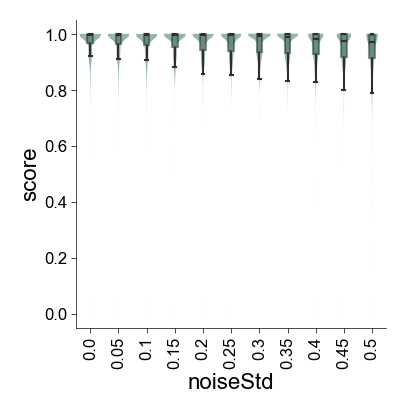

In [79]:
sns.violinplot(simScore.astype(float).melt(var_name="noiseStd",value_name="score"),x="noiseStd",y="score",edgecolor=None,inner=None,cut=0,alpha=0.5,color=mnColor)
# sns.stripplot(simScore.astype(float).melt(var_name="noiseStd",value_name="score"),x="noiseStd",y="score",size=2**0.75,jitter=0.34,color=mnColor)

sns.boxplot(simScore.astype(float).melt(var_name="noiseStd",value_name="score"),x="noiseStd",y="score",width=0.2,linewidth=0.75,fliersize=2**0.75,
            boxprops={"alpha":0.5,},showfliers=False,color=mnColor)
plt.xticks(rotation=90)


(-1.0, 10.0)

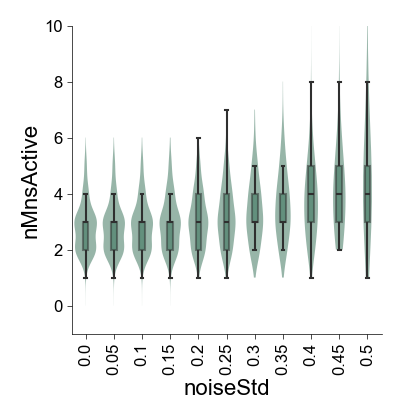

In [80]:
sns.violinplot(nMnsActive.astype(float).melt(var_name="noiseStd",value_name="nMnsActive"),x="noiseStd",y="nMnsActive",edgecolor=None,inner=None,cut=0,alpha=0.5,color=mnColor,bw_adjust=2)
# sns.stripplot(nMnsActive.astype(float).melt(var_name="noiseStd",value_name="nMnsActive"),x="noiseStd",y="nMnsActive",size=2**0.75,jitter=0.34,color=mnColor)

sns.boxplot(nMnsActive.astype(float).melt(var_name="noiseStd",value_name="nMnsActive"),x="noiseStd",y="nMnsActive",width=0.2,linewidth=0.75,fliersize=2**0.75,
            boxprops={"alpha":0.5,},showfliers=False,color=mnColor)
plt.xticks(rotation=90)
plt.ylim([-1,10])


In [84]:
if not os.path.exists(figFolder):
    os.makedirs(figFolder)
nMnsActive.to_csv(figFolder+"/nMnsActive.csv")
simScore.to_csv(figFolder+"/scores.csv")
mnFreq.to_csv(figFolder+"/frequencies.csv")
# for some reason I don't have permissio to save to the original data folder

## MANC DNg100 activation $|I_\text{stim}|$ sweep

In [1]:
import pandas as pd

In [3]:
wTable = pd.read_csv("../data/fanc t1l connectome data/wTable_BDN2toMN_20250107_withClass.csv",index_col=0)
wTable

,index,id,created,superceded_id,valid,classification_system,cell_type,pt_supervoxel_id,pt_root_id,pt_position_nrn,w_type,sign,w_idx,pt_position_soma,surf_area_um2,motor module,step contribution,class
0,0,2035,2023-04-24 14:42:19.357167+00:00,NaN,t,neck connective (left),BDN2,73115599907537415,648518346459693060,[31751 75200 1673],BDN2,1,0,NaN,23069.083942,NaN,NaN,descending neuron
1,0,2143,2024-01-08 20:53:15.131162+00:00,NaN,t,01A,01A,73468131427083744,648518346504284712,[41340 96096 2759],01A,1,1,[38168 90824 2634],9469.012551,NaN,NaN,intrinsic neuron
2,1,2144,2024-01-08 20:53:15.158995+00:00,NaN,t,01A,01A,73186656181815355,648518346497947239,[33186 95356 2194],01A,1,2,[37696 90560 2006],3063.941793,NaN,NaN,intrinsic neuron
3,2,2145,2024-01-08 20:53:15.172331+00:00,NaN,t,01A,01A,73327393938694824,648518346475560289,[38436 95894 2759],01A,1,3,[41752 83872 2221],4396.551071,NaN,NaN,intrinsic neuron
4,3,2151,2024-01-08 20:53:15.248424+00:00,NaN,t,01A,01A,73397831402402673,648518346486131838,[39600 96566 2759],01A,1,4,[42744 89528 2353],11461.846836,NaN,NaN,intrinsic neuron
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
798,89,338,2022-05-02 19:38:10.081892+00:00,NaN,t,V1_T1L,trochanter_flexor_in_coxa_Vn,72623431350591952,648518346488137239,[17632 86321 2265],trochanter_flexor_in_coxa_Vn,1,798,[18608 86048 2266],11498.924616,femur/tr flex,stance,motor neuron
799,90,340,2022-05-02 19:38:10.106961+00:00,NaN,t,V3_T1L,tergotrochanter_in_thorax_0,73045781120322699,648518346496195084,[30633 90820 1976],tergotrochanter_in_thorax_0,1,799,[29664 90984 1980],12382.598003,femur/tr extend,swing,motor neuron
800,91,342,2022-05-02 19:38:10.131499+00:00,NaN,t,V2_T1L,tergotrochanter_in_thorax_2,72975343589667059,648518346514458155,[28266 88474 1899],tergotrochanter_in_thorax_2,1,800,[27680 87720 1905],12516.355282,femur/tr extend,swing,motor neuron
801,92,344,2022-05-02 19:38:10.303690+00:00,NaN,t,V5_T1L,extracoxal_trochanter_depressor_in_thorax_Vn,72975275205735565,648518346514306270,[27494 86790 2515],extracoxal_trochanter_depressor_in_thorax_Vn,1,801,[28080 85768 2516],12593.692730,femur/tr extend,swing,motor neuron


In [4]:
wTable.loc[wTable["w_type"]=="BDN2","w_type"] = "DNg100"
inxxx464 = wTable.loc[wTable["pt_supervoxel_id"]==72905112552773752]
wTable.loc[inxxx464.index,"w_type"] = "TBD"
wTable.loc[wTable["w_type"]=="X","w_type"] = "TBD"
wTable.loc[inxxx464.index,"sign"] = 1
wTable

,index,id,created,superceded_id,valid,classification_system,cell_type,pt_supervoxel_id,pt_root_id,pt_position_nrn,w_type,sign,w_idx,pt_position_soma,surf_area_um2,motor module,step contribution,class
0,0,2035,2023-04-24 14:42:19.357167+00:00,NaN,t,neck connective (left),BDN2,73115599907537415,648518346459693060,[31751 75200 1673],DNg100,1,0,NaN,23069.083942,NaN,NaN,descending neuron
1,0,2143,2024-01-08 20:53:15.131162+00:00,NaN,t,01A,01A,73468131427083744,648518346504284712,[41340 96096 2759],01A,1,1,[38168 90824 2634],9469.012551,NaN,NaN,intrinsic neuron
2,1,2144,2024-01-08 20:53:15.158995+00:00,NaN,t,01A,01A,73186656181815355,648518346497947239,[33186 95356 2194],01A,1,2,[37696 90560 2006],3063.941793,NaN,NaN,intrinsic neuron
3,2,2145,2024-01-08 20:53:15.172331+00:00,NaN,t,01A,01A,73327393938694824,648518346475560289,[38436 95894 2759],01A,1,3,[41752 83872 2221],4396.551071,NaN,NaN,intrinsic neuron
4,3,2151,2024-01-08 20:53:15.248424+00:00,NaN,t,01A,01A,73397831402402673,648518346486131838,[39600 96566 2759],01A,1,4,[42744 89528 2353],11461.846836,NaN,NaN,intrinsic neuron
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
798,89,338,2022-05-02 19:38:10.081892+00:00,NaN,t,V1_T1L,trochanter_flexor_in_coxa_Vn,72623431350591952,648518346488137239,[17632 86321 2265],trochanter_flexor_in_coxa_Vn,1,798,[18608 86048 2266],11498.924616,femur/tr flex,stance,motor neuron
799,90,340,2022-05-02 19:38:10.106961+00:00,NaN,t,V3_T1L,tergotrochanter_in_thorax_0,73045781120322699,648518346496195084,[30633 90820 1976],tergotrochanter_in_thorax_0,1,799,[29664 90984 1980],12382.598003,femur/tr extend,swing,motor neuron
800,91,342,2022-05-02 19:38:10.131499+00:00,NaN,t,V2_T1L,tergotrochanter_in_thorax_2,72975343589667059,648518346514458155,[28266 88474 1899],tergotrochanter_in_thorax_2,1,800,[27680 87720 1905],12516.355282,femur/tr extend,swing,motor neuron
801,92,344,2022-05-02 19:38:10.303690+00:00,NaN,t,V5_T1L,extracoxal_trochanter_depressor_in_thorax_Vn,72975275205735565,648518346514306270,[27494 86790 2515],extracoxal_trochanter_depressor_in_thorax_Vn,1,801,[28080 85768 2516],12593.692730,femur/tr extend,swing,motor neuron
